<img src="../img/GTK_Logo_Social Icon.jpg" width=175 align="right" />


# Worksheet 6.0 Clustering - Answers

This worksheet covers concepts relating to Unsupervised Learning.  It should take no more than 20-30 minutes to complete.  Please raise your hand if you get stuck.  

There are many ways to accomplish the tasks that you are presented with, however you will find that by using the techniques covered in class, the exercises should be relatively simple. 

## Import the Libraries
For this exercise, we will be using:
* Pandas (https://pandas.pydata.org/pandas-docs/stable/)
* Numpy (https://docs.scipy.org/doc/numpy/reference/)
* Matplotlib (https://matplotlib.org/stable)


In [1]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import kneighbors_graph
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
import matplotlib.pyplot as plt
from matplotlib import style
from scipy.spatial.distance import cdist
style.use("ggplot")
%matplotlib inline

# Clustering with Real Data
Let's try it on some real data and see what we can produce. As before the first step is to read in the data into a DataFrame.  

We will be using this data later, but the dataset consists of approximately 6000 domains--5000 of which were generated by various botnets and 1000 are from the Alexa 1 Million.  The columns are:

* `dsrc`:  The source of the domain
* `domain`:  The actual domain
* `length`:  The length of the domain
* `dicts`:  Percentage containing dictionary words
* `entropy`:  The entropy of the domain
* `numbers`:  The number of digits in the domain
* `ngram`:  Different n-grams which appear in the domain (?)

In [2]:
data = pd.read_csv('../data/dga-full.csv')
data.sample(5)

,dsrc,domain,length,dicts,entropy,numbers,ngram
37121,nivdort,picktold,8,1.000,3.000000,0,5.550003
26225,necurs,rxomfsok,8,0.625,2.750000,0,0.477121
30493,necurs,hvglddpndjwj,12,0.500,3.022055,0,0.000000
33816,nivdort,offernerve,10,1.000,2.446439,0,14.822793
26299,necurs,ncqcxkbhruwt,12,0.000,3.418296,0,0.000000


In [3]:
data['dsrc'].value_counts()

dsrc
cryptolocker    10000
gameoverdga     10000
necurs          10000
alexa           10000
nivdort          9978
bamital          2500
Name: count, dtype: int64

## Scaling the Data
Since clustering relies on measuring distances between objects it is important that all data points be on the same scale.  There are various methods for doing this, which are beyond the scope of this class, however, for this example, we will use scikit-learn's `StandardScaler` to accomplish this.  (http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

The StandardScaler transforms each column by:
* Subtracting from the element in each row the mean for each feature (column) and then taking this value and
* Dividing by that feature's (column's) standard deviation.

Scikit-learn has a transformer interface which is very similar to the other scikit-learn interfaces.  The basic steps are:
1.  Create the Scaler object
2.  Using the feature matrix, call the `.fit()` method to "train" the Scaler
3.  Use the `.transform()` method to scale the data.

**NOTE**: When using a Scaler, it is important to train the scaler on your data, and use this trained scalers on any future predictions. 

In [4]:
feature_columns = ['length', 'dicts','entropy','numbers','ngram']
scaled_feature_columns = ['scaled_length', 'scaled_dicts','scaled_entropy','scaled_numbers','scaled_ngram']

In [5]:
#Step 1:  Create the scaler
scaler = StandardScaler()

#Steps 2 & 3:  Fit the scaler and transform this data
scaled_df = scaler.fit_transform(data[feature_columns])

#Put the scaled data into a dataframe
scaled_df = pd.DataFrame(scaled_df, columns=scaled_feature_columns)

Take a look at the data and you'll see that the data is now all scaled consistently. 

In [6]:
scaled_df.sample(10)

,scaled_length,scaled_dicts,scaled_entropy,scaled_numbers,scaled_ngram
28101,-0.277145,-0.124203,0.009387,-0.498385,-0.511922
17981,1.166731,-0.917330,1.270821,1.020643,-0.653574
41675,-0.933453,1.144799,-0.833959,-0.498385,1.487011
18224,1.429253,-1.604706,1.236128,0.451007,-0.811719
39354,-0.802191,1.144799,-0.876255,-0.498385,1.097684
45635,-0.670930,1.144799,-1.012599,-0.498385,1.167541
27540,-1.064714,-0.426347,-1.227875,-0.498385,-0.642722
33437,-0.802191,1.144799,-0.492925,-0.498385,0.441494
20026,1.429253,-1.287455,1.734368,1.970035,-0.811719
21895,1.560515,-0.891871,1.346670,1.400399,-0.666102


Finally for convenience, we're going to merge the scaled data with the non-scaled data.  

In [7]:
final_data = pd.merge( data, scaled_df, left_index=True, right_index=True)

In [8]:
final_data.sample(5)

,dsrc,domain,length,dicts,entropy,numbers,ngram,scaled_length,scaled_dicts,scaled_entropy,scaled_numbers,scaled_ngram
39263,nivdort,hangnovember,12,1.000000,3.251629,0,11.404309,-0.408407,1.144799,0.031342,-0.498385,1.322396
25370,necurs,kstqfqqenrgueshikuwf,20,0.400000,3.584184,0,5.812780,0.641685,-0.504904,0.604992,-0.498385,0.276040
14072,gameoverdga,569s941i4avh1imkh11h5vilj,25,0.120000,3.623465,11,1.146128,1.297992,-1.274765,0.672752,1.590278,-0.597241
16572,gameoverdga,eojypb1n20ltp1ec0rh518qvjl6,27,0.111111,4.208410,9,0.000000,1.560515,-1.299205,1.681771,1.210521,-0.811719
42013,nivdort,hanglight,9,1.000000,2.725481,0,13.291352,-0.802191,1.144799,-0.876255,-0.498385,1.675522


### Your Turn!
Now that we have data that is suitable (maybe) for clustering, in the section below, perform K-Means clustering on this data set.  Initially, start out with 2 clusters and assign the `cluster id` as a column in your DataFrame.

Then do a `value_counts()` on the `dsrc` column for each cluster to see how the model divided the data.  Try various values for `k` to see how it performed.

Remember to use the **scaled features** for your clustering.  

In [9]:
## Your code here...

kmeans = KMeans(n_clusters=6, n_init=2).fit(final_data[scaled_feature_columns])

centroids = kmeans.cluster_centers_
labels = kmeans.labels_

print(centroids)
print(labels)

[[ 1.41889771 -1.12015978  1.37549261  1.12447031 -0.61353029]
 [-0.11020386 -0.24280475  0.19326302 -0.49671211 -0.46089709]
 [-0.17938934  1.0901334  -0.110026   -0.49274704  3.11763325]
 [-1.17819083 -0.10596643 -1.74374472 -0.440618   -0.56163058]
 [-0.78600454  1.08762703 -0.6988562  -0.49417663  0.71325333]
 [ 2.19589568 -1.37946486  0.66101107  3.26611297 -0.71389355]]
[5 5 5 ... 2 3 2]


In [10]:
final_data['dsrc'].value_counts()

dsrc
cryptolocker    10000
gameoverdga     10000
necurs          10000
alexa           10000
nivdort          9978
bamital          2500
Name: count, dtype: int64

In [11]:
final_data['cluster_id'] = kmeans.labels_

In [12]:
final_data['cluster_id'].value_counts()

cluster_id
1    17710
4    15436
0     9912
3     4413
5     2578
2     2429
Name: count, dtype: int64

In [19]:
final_data[final_data['cluster_id'] ==5]['dsrc'].value_counts()

dsrc
bamital        2496
gameoverdga      81
alexa             1
Name: count, dtype: int64

In [26]:
final_data['domain'][(final_data['cluster_id'] == 0)].sample(20)

13667       mintfp9yj1hqe2fn4d14h26xj
20165    1sawzmb192yygh1g2rqhm1943hpl
16504     16d0r4j1dge93u1853losn7a92x
16660      12nh8n7bxgszryqlstk1wn8rx7
20134      19rcelxbgk7nmcnrxav1a6ckav
14035     kbrtl41hc4l9s100kqtn13ny2bw
17771         f9iyx78k36szw5q779jcelj
20558        y4wbf6p9g6suj850213nsllh
21786     12qhrn81f6r3yt17l9gog79oli4
18357      nh5r0hnfzpj21or4u1x18bu6la
22356       25y6te5587i01t2fzqsvnrgjk
12771     1cdbpoy1yrdang1u4b5x1ajx0d4
18046      1b1o705811rum16ydsmp1f7gj1
20801       1l10midx6wgheud5fzihqjzdb
15540        6h7b8tlrrfa1m6oldxd8b6qs
18829      1kaf5aqiboyswz40zva18v810k
20530     1f3eq4f16up6a11idry2cbol7n9
22474      14x9rjivct0tvhxnya21odni8o
17480     1u59iexe5higw1om0sh21yxxb2b
15280       a6fmdx1ok1v25zosqd8r4ld6n
Name: domain, dtype: object

In [49]:
final_data[final_data['cluster_id'] == 0]['domain'].sample(15)

51218       indieshuffle
37019           hilljune
35127         wrongpeace
49765          devisprox
47873           brandear
39842           lookride
46563            hungama
48879    ashleyfurniture
46501         driveropti
46400        arakamk-uni
39990          wifelight
42255           wentthey
32679          feltshirt
34484         thisheight
49170      takarakujinet
Name: domain, dtype: object

In [25]:
final_data['domain'][final_data['dsrc'] == 'cryptolocker'].sample(5)

11305    knymgpuofsxhgyw
10279     vijldrtgicnukc
11684       jocdqdhyvpxo
12101     gqixppynaqcnav
11839      rtqmpifttdpev
Name: domain, dtype: object

In [26]:
final_data[final_data['dsrc'] == "bamital"]['domain'].sample(10)

976     752c647388b264fbf60928908328907d
1988    714024e038d6b57434c49be2dda03fe9
116     4ef1c06728a8bdf9c90d40089bc3cc8d
2471    f328644ae140cdc03f8ac48b5796a2f0
2111    d6d572638b348695e7552cd0cb0d8bf1
868     447802cb59b0d61f8529aa11b4ca427d
842     fc0c35e58ffffd185d68395840efd6ac
1522    fdec5826c182b9df4b2b53349c55c2ac
1877    bbe3fb794fa772899028308d8b81b41d
578     df6db8ead36287dce161f2a3e6b5ae28
Name: domain, dtype: object

In [27]:
final_data[final_data['dsrc'] == "nivdort"]['domain'].sample(10)

33775      deadgives
37834     spendprice
34971     hangheight
32918       jumpheld
35824      lordreach
37047      drinkkind
36548      dutypress
34427    ariveheight
35228       thenpaid
33963    deadoctober
Name: domain, dtype: object

In [32]:
final_data[(final_data['cluster_id'] == 1) & (final_data['dsrc'] == 'necurs')]['domain']

22546    kujnifxvqwkpyytegqohv
22632     xwhqnkkesylwbydfnsxm
22711       wuiioaeyklhgcxwmad
22736       efkwmijhtpxsgrhfgq
22743      shngncqtfjlfhdjrtks
                 ...          
31897    pyskufklybvjhfpywtvlc
31956      ixhlkocwfwwdktjmdvj
32246     sxgkkqnnfjsoyhebpypw
32434    cqvkgxsntoevqbkxnyvyf
32456    qxvbbtlxhwguongdywukl
Name: domain, Length: 140, dtype: object

In [33]:
final_data.sample(5)

,dsrc,domain,length,dicts,entropy,numbers,ngram,scaled_length,scaled_dicts,scaled_entropy,scaled_numbers,scaled_ngram,cluster_id
7906,cryptolocker,dywyosnjawtp,12,0.666667,3.251629,0,0.778151,-0.408407,0.228297,0.031342,-0.498385,-0.666102,0
22294,gameoverdga,1fqlglzuy23q459xqwe1jp626z,26,0.000000,4.132944,10,0.000000,1.429253,-1.604706,1.551594,1.400399,-0.811719,1
38889,nivdort,deadpure,8,1.000000,2.500000,0,6.623038,-0.933453,1.144799,-1.265204,-0.498385,0.427666,0
52175,alexa,centurybroker,13,1.000000,3.180833,0,14.859370,-0.277145,1.144799,-0.090780,-0.498385,1.968949,0
10338,cryptolocker,qcpfnypomciijld,15,0.533333,3.506891,0,1.176091,-0.014622,-0.138303,0.471663,-0.498385,-0.591634,0


## Food for thought:
Now that you've done clustering with various numbers of clusters, it appears that the data acutally does break evenly into 2 clusters.  Take a look at the original data and see if you can come up with a reason why that is the case.

## Visualizing Performance
As we already know, it is difficult to measure the performance of clustering models since there usually is no known ground truth from which to evaluate your model.  However, there are two techniques which 

The K-Elbow Visualizer implements the “elbow” method of selecting the optimal number of clusters for K-means clustering. K-means is a simple unsupervised machine learning algorithm that groups data into a specified number (k) of clusters. Because the user must specify in advance what k to choose, the algorithm is somewhat naive – it assigns all members to k clusters even if that is not the right k for the dataset.

The elbow method runs k-means clustering on the dataset for a range of values for k (say from 1-10) and then for each value of k computes an average score for all clusters. By default, the distortion_score is computed, the sum of square distances from each point to its assigned center. Other metrics can also be used such as the silhouette_score, the mean silhouette coefficient for all samples or the calinski_harabaz_score, which computes the ratio of dispersion between and within clusters.

When these overall metrics for each model are plotted, it is possible to visually determine the best value for K. If the line chart looks like an arm, then the “elbow” (the point of inflection on the curve) is the best value of k. The “arm” can be either up or down, but if there is a strong inflection point, it is a good indication that the underlying model fits best at that point. (http://www.scikit-yb.org/en/latest/api/cluster/elbow.html)

In python there is a module called `YellowBrick` which facilitates visualizing the K-Elbow score.  All of YellowBrick's visualizations follow essentually the same pattern:

1.  Create the Visualizer Object
2.  Call the `.fit()` method using the data
3.  Call the `.show()` method to render the visualization

The snippet below demonstrates how to use the elbow method to visualize the clustering model's performance on this dataset.
```python
visualizer = KElbowVisualizer(KMeans(), k=(4,12))

visualizer.fit( feature_matrix ) 
visualizer.show()
```

### Your Turn!
In the box below, create a visualization using the elbow method to see if there are any inflection points in the distortion score.

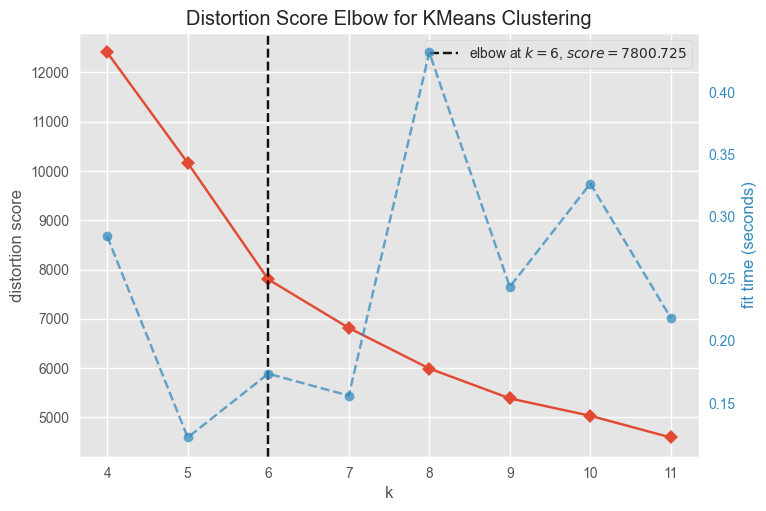

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [27]:
# Your code here...
visualizer = KElbowVisualizer(KMeans(n_init=2), k=(4,12), metric='distortion')

visualizer.fit(final_data[scaled_feature_columns].sample(10000))
visualizer.show()

## Another Way to Visualize Clustering Performance
The Silhouette Coefficient is used when the ground-truth about the dataset is unknown and computes the density of clusters computed by the model. The score is computed by averaging the silhouette coefficient for each sample, computed as the difference between the average intra-cluster distance and the mean nearest-cluster distance for each sample, normalized by the maximum value. This produces a score between 1 and -1, where 1 is highly dense clusters and -1 is completely incorrect clustering. (http://www.scikit-yb.org/en/latest/api/cluster/silhouette.html)


### Your Turn!
Using the YellowBrick `SilhouetteVisualizer`, try visualizing models with various values of `K`.

**Note**:  This visualization is quite expensive, so I recommend performing this using a sample o your original data.

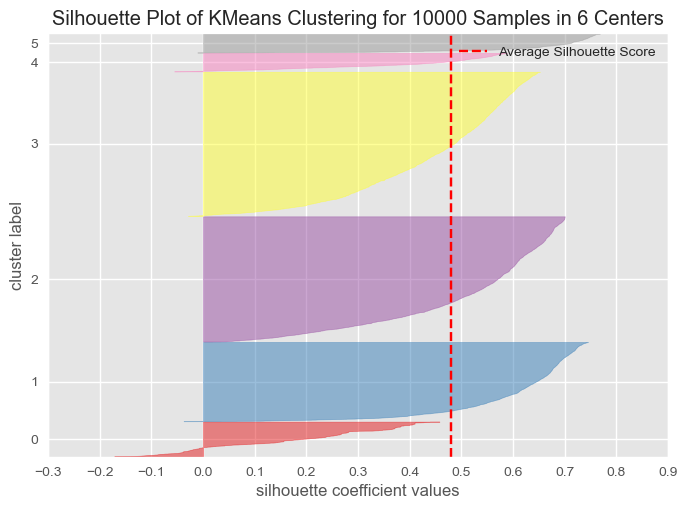

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 10000 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [41]:
# Your code here...
visualizer = SilhouetteVisualizer( KMeans(n_clusters=6, n_init=3))

visualizer.fit(final_data[scaled_feature_columns].sample(10000))
visualizer.show()

## Anomaly Detection using Clustering methods
Let's use a hierarchical clustering method to detect anomalies in a set of data points. The one we will use is called (agglomerative clustering)[https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html]. 

First we will create a dataset that only has 20 DGA rows and 1000 legit samples. Thus, there are 20 anomalies in this dataset that we know of. Then we will see if our clustering method can detect them. 

In [78]:
dga_data = pd.read_csv('../data/dga_features_final_df_domain.csv')
print(dga_data.isDGA.value_counts())

1    1000
0    1000
Name: isDGA, dtype: int64


In [79]:
is_dga = dga_data[dga_data['isDGA']==1].sample(10)
not_dga = dga_data[dga_data['isDGA']==0]

In [80]:
print(len(is_dga))
print(len(not_dga))

10
1000


In [81]:
dga_anomaly_data = pd.concat([is_dga, not_dga])
dga_anomaly_data['isDGA'].value_counts()

0    1000
1      10
Name: isDGA, dtype: int64

In [83]:
dga_anomaly_data_domain = dga_anomaly_data
dga_anomaly_data = dga_anomaly_data.drop('domain',axis=1)

#### Now use this dataset in clustering

First we want to scale the data because it is clustering which means that distance is important and that is extremely sensitive to different scales. Use either the Standard Scaler or Min Max Scaler from sklearn to scale our data set.

In [84]:
dga_anomaly_data  = StandardScaler().fit_transform(dga_anomaly_data)

Now that we have prepared the data, we can put it into a model. Call the Agglomerative Clustering model from sklearn and fit it to the data. name the model **agglomerative_clust**

In [85]:
agglomerative_clust = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

# Your code here
agglomerative_clust = agglomerative_clust.fit(dga_anomaly_data)

# pull out the label of the cluster each point belongs to. 
labels_for_clusters = agglomerative_clust.labels_

This plot_dendrogram function will plot the dendrogram for the cluster model you just fitted to the data. 

In [86]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

Use the plot_dendrogram function to plot the dendrogram. You an get lower and lower levels if you increase the value of **p**. Try plotting a few values of **p** to see the difference and notice what happens.

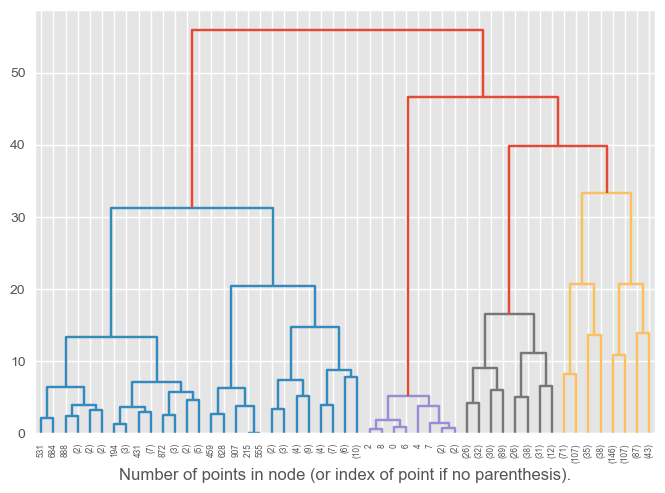

In [87]:
plot_dendrogram(agglomerative_clust, truncate_mode="level", p=5);
plt.xlabel("Number of points in node (or index of point if no parenthesis).");


Notice that in the plot there are some digits on the x-axis with no parenthesis. These are nodes that did not have more than 1 data point. We want to take a look at these because they are 'far' enough away from the rest of the data to warrant their own node, and thus could be an anomaly. 

Below, use the original pandas data frame to print the rows of the single nodes and see if these are our few DGAs. 

In [88]:
dga_anomaly_data_domain.iloc[0,:]

isDGA                               1
domain             wcksansymoxgibjfkx
length                             18
digits                              0
entropy                      3.836592
vowel-cons                        0.2
firstDigitIndex                     0
ngrams                     826.658497
Name: 663, dtype: object

In [71]:
dga_anomaly_data_domain.iloc[3,:]

isDGA                                       1
domain             15ihbm71utcnfa8dk1mmgoobl9
length                                     26
digits                                      7
entropy                              4.180833
vowel-cons                           0.357143
firstDigitIndex                             1
ngrams                             682.269402
Name: 3, dtype: object

In [90]:
dga_anomaly_data_domain.iloc[5,:]

isDGA                            1
domain             uyphoykvvmxetnf
length                          15
digits                           0
entropy                   3.640224
vowel-cons                    0.25
firstDigitIndex                  0
ngrams                  779.403541
Name: 970, dtype: object

In [89]:
dga_anomaly_data_domain.iloc[29,:]

isDGA                         0
domain             skidrowgames
length                       12
digits                        0
entropy                3.418296
vowel-cons                  0.5
firstDigitIndex               0
ngrams               1337.05303
Name: 1019, dtype: object

Another thing to note is just to look at the contents of the smallest cluster (depending on how small you think your anomalies are. IN this case our smallest cluster contains the DGAs. Thus, our model accurately pulled out the DGAs into their own 'anomaly' cluster. 

## DBSCAN
Another clustering method we can try is DBSCAN (http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html).  Remember that the main tuning parameters for DBSCAN are:

* **epsilon (eps)**:  The minimum distance between two samples 
* **min_samples**:  The minimum number of samples needed to form a neighborhood

By default epsilon is 0.5 and the min_samples is 5. First, try DBSCAN with the default options.  If you use the `fit_predict()` function, you can save the results in a new column in your data.  

How did this compare with K-Means?  Given that you actually know what the data really is, how did DBSCAN do in terms of identifing meaningful clusters?  Look at the `dsrc` column and do `value_counts()` for the various neighhborhoods.  What did you notice?

Try again, but this time experiment with the values of epsilon and min_samples and see what DBSCAN comes up with. 

In [29]:
dbscan = DBSCAN(min_samples=5, n_jobs=4)

In [30]:
final_data['dbs_default'] = dbscan.fit_predict(final_data[scaled_feature_columns])

In [31]:
final_data['dbs_default'].value_counts()

dbs_default
 1    49777
 0     2501
 4      119
-1       50
 3       23
 2        8
Name: count, dtype: int64

In [32]:
final_data[final_data['dbs_default'] == 0 ]['dsrc'].value_counts()

dsrc
bamital    2500
alexa         1
Name: count, dtype: int64

In [38]:
final_data[final_data['dbs_default'] == 0][['dsrc','domain']].sample(10)

,dsrc,domain
2351,bamital,349d71670d7f3ffd2470ec556eb80d11
2115,bamital,6264e9a0a10845443ef1689b4d78da57
1993,bamital,ed261dd64e3f1a6c3191b1d39e82853d
667,bamital,a382ab8128ef1e31ef91aedba7a1afc1
1110,bamital,b27f41f008a7a5029561a9319b3ec794
2474,bamital,4a343f97fd5aefcab2cce41130a12fd7
1951,bamital,9d6e51f39d5edae349a2f7aa3da3dfbc
2456,bamital,56f4691aa5b13a37ebfa5af595022462
930,bamital,b297c615640cfd02b86ea56c0314ed75
755,bamital,e1caf8f3e1d2a2ff0f65884ce942bdcf


In [39]:
final_data[final_data['dbs_default'] == -1 ]['dsrc'].sample(10)

50135          alexa
21566    gameoverdga
49102          alexa
26731         necurs
48855          alexa
48436          alexa
46458          alexa
45940          alexa
48806          alexa
47710          alexa
Name: dsrc, dtype: object

In [40]:
final_data['domain'][final_data['dsrc'] == "nivdort"].sample(5)

40643    withthousand
40681    meatsaturday
34042       hairunder
33613     spotoctover
37288       visitborn
Name: domain, dtype: object

In [43]:
final_data[final_data['dbs_default'] == 2 ]['dsrc'].value_counts()

dsrc
alexa    8
Name: count, dtype: int64

In [31]:
final_data[final_data['dbs_default'] == 1 ]['dsrc'].value_counts()

cryptolocker    10000
necurs           9990
nivdort          9978
alexa            9330
gameoverdga         3
Name: dsrc, dtype: int64

In [32]:
final_data[final_data['dsrc'] == "cryptolocker"]['domain'].sample(10)

10649       wbirarkhsfgf
8792        ffkwsvsieexl
11876      gkjsqegicfuxs
7565       btahdqypypsbp
12072     xjlepuhmjvycjt
8145     gxaakkrvirymuuk
11432    qnvysekkbpwpnmo
3825        qmvuvtftlhws
7031        hgttabqebluy
5041        iyiwxusxdvke
Name: domain, dtype: object

In [33]:
final_data[final_data['dsrc'] == "necurs"]['domain'].sample(10)

32316          ptgctebbvohb
31865    vwhilgweujpuliijvs
26512     ksyaqkudmuorqdsnx
30930           kmtleqvxqvk
24248     rtatnpxrleuyjfvmr
27666     rlgawlqrvgkskeisa
24989            uegqqmllfr
22616          defellojyrqw
22599            jhkoqfmwjo
26324     vrdimsspkhpbyvwjo
Name: domain, dtype: object